# Introduction
In this notebook we will extract patterns formed between observed and latent variables as learnt from a deep generative model, specifically a variational autoencoder (VAE). Log-linear models are step-wise fit to discretized synthetic data sampled from the VAE. The method is demonstrated on single cell RNA-Seq data from [Tasic et al. 2016](https://www.nature.com/articles/nn.4216) you already got acquainted with in the morning session. Details about fitting log-linear models can be found in [Hess et al. 2020](https://academic.oup.com/bioinformatics/article/36/20/5045/5869514).

We will start with a VAE for Bernoulli distributed data. To that end, we will discretize the scRNA-Seq data. Later, we will employ an scVAE such as introduced in [Lopez et al. 2018](https://www.nature.com/articles/s41592-018-0229-2).

# Loading and installing necessary packages

In [1]:
using Pkg; 
cd(@__DIR__)
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Downloads/moritz_maren`


In [2]:
Pkg.upgrade_manifest()
Pkg.resolve()

LoadError: Format of manifest file at `/Users/moritz/Downloads/moritz_maren/Manifest.toml` already up to date: manifest_format == 2.0.0

In [3]:
using Pkg
Pkg.add(["Clustering","Seaborn","PyPlot","UMAP","LinearAlgebra","Distances","Distributions","Random","Flux","Zygote","SpecialFunctions","StatsBase","Statistics","DelimitedFiles"])
Pkg.add(url="https://github.com/ssehztirom/LogLinearModels.jl")
Pkg.add(url="https://github.com/ssehztirom/patternextractor.jl")
Pkg.add(url="https://github.com/maren-ha/scVI.jl")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Downloads/moritz_maren/Project.toml`
  No Changes to `~/Downloads/moritz_maren/Manifest.toml`
    Updating git-repo `https://github.com/ssehztirom/LogLinearModels.jl`
   Resolving package versions...
  No Changes to `~/Downloads/moritz_maren/Project.toml`
  No Changes to `~/Downloads/moritz_maren/Manifest.toml`
    Updating git-repo `https://github.com/ssehztirom/patternextractor.jl`
   Resolving package versions...
  No Changes to `~/Downloads/moritz_maren/Project.toml`
  No Changes to `~/Downloads/moritz_maren/Manifest.toml`
    Updating git-repo `https://github.com/maren-ha/scVI.jl`
   Resolving package versions...
    Updating `~/Downloads/moritz_maren/Project.toml`
  [add38077] ~ scVI v0.1.0 `https://github.com/maren-ha/scVI.jl#main` ⇒ v0.1.0 `https://github.com/maren-ha/scVI.jl#main`
    Updating `~/Downloads/moritz_maren/Manifest.toml`
  [add38077] ~ scVI v0.1.0 `https

In [4]:
using PyPlot
using UMAP
using LinearAlgebra
using Distributions
using Random
using Flux
using Zygote
using SpecialFunctions
using LogLinearModels
using PatternExtractor
using StatsBase
using Statistics
using DelimitedFiles
using Distances
using Clustering
using Seaborn
using scVI 

# Some helper functions

In [5]:
# Standardize gene expression data.
function zscores(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

# Principal component analysis (PCA)
function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = zscores(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end

# hierarchically clusters gene expression matrix, function returns distances of rows, columns, 
# ordering of rows, ordering of columns and the reordered matrix
function cluster_matrix(mat;clustern=true,clusterp=true)
    ndist = pairwise(Distances.Euclidean(),mat,dims=1)
    pdist = pairwise(Distances.Euclidean(),mat,dims=2)
    norder = hclust(ndist,:complete).order
    porder = hclust(pdist,:complete).order
    if clustern
        mat = mat[norder,:]
    end
    if clusterp
        mat = mat[:,porder]
    end
    return ndist,pdist,norder,porder,mat
end

# Function to dichotomize data at "selquantile"
function dichotomize(x;selquantile=0.5)
	n,p=size(x)
	dicho = zeros(n,p)
	for i=1:p
		dicho[:,i] = ifelse.(x[:,i] .>quantile(x[:,i],selquantile),1.0,0.0)
	end
	return dicho
end

# function for reformatting samples from a VAE, data is just restructured, no magic happening here.
function reformatsamples(samples)
    zs = fill(0.0,length(samples),length(samples[1][1]))
    xs = fill(0.0,length(samples),length(samples[1][2]))
    for i = 1:length(samples)
        zs[i,:] = samples[i][1]
        xs[i,:] = samples[i][2]
    end
    return zs,xs
end



reformatsamples (generic function with 1 method)

# Code for training VAEs

In [6]:
# a struct defining a variational autoencoder
struct VAE
	encoder
	mu
	logsigma
	decoder
end

# cross entropy between reconstruction and observed data
function logp_x_z(xhat,x)
	ce(x,y) =  y * log(x + eps()) + (1 - y) * log(1 - x + eps())
	return sum(ce.(xhat,x))
end

# Sampling from a Gaussian distribution with expectation mu and standard deviation exp(logsigma)
function latentz(mu,logsigma)
	return mu  + exp(logsigma) * randn()
end


# Kullback Leibler divergence between posterior distribution and Gaussian distribution
function kl_q_p(mu,logsigma)
	return 0.5 * sum(exp.(2 .* logsigma) + mu.^2 .- 1 .- 2 .* logsigma)
end

# get values for the parameters of the posterior distribution
g(x) = (h = vae.encoder(x); (vae.mu(h), vae.logsigma(h)))	

# Combined loss function
loss(x) = ((mu,logsigma) = g(x);
    (sum(logp_x_z(vae.decoder(latentz.(mu,logsigma)),x))
        - Beta * kl_q_p(mu,logsigma)) / batchsize)


loss (generic function with 1 method)

Here we specify functions for sampling from the prior or the posterior distribution.

In [7]:
function posteriorsample(x) 
    mu,logsigma = g(x)
    zs = latentz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

function priorsample(x) 
    mu,logsigma = g(x)
    mu = zeros(length(mu))
    logsigma = zeros(length(logsigma))
    zs = latentz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

priorsample (generic function with 1 method)

## Starting with a VAE with Bernoulli distributed observed variables

Loading Tasic et al. Data 1) gene expression matrix, 2) cell type labels 3) genenames

In [8]:
x = readdlm("data/single_cell_mat.txt",'\t')'

1525×180 adjoint(::Matrix{Float64}) with eltype Float64:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                       

We inspect the distribution of a random selection of genes.

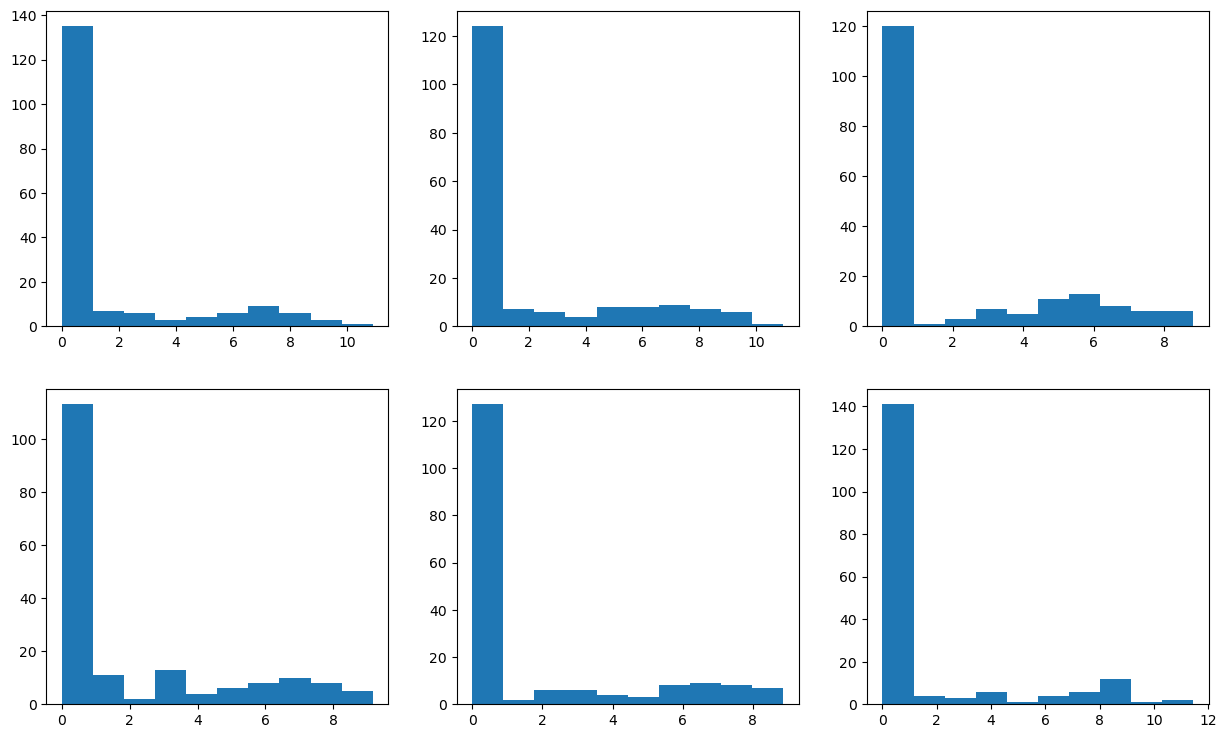

([141.0, 4.0, 3.0, 6.0, 1.0, 4.0, 6.0, 12.0, 1.0, 2.0], [0.0, 1.1445869201476588, 2.2891738402953177, 3.4337607604429765, 4.578347680590635, 5.722934600738294, 6.867521520885953, 8.012108441033611, 9.15669536118127, 10.30128228132893, 11.445869201476588], (PyObject <matplotlib.patches.Rectangle object at 0x240f6adf0>, PyObject <matplotlib.patches.Rectangle object at 0x240f4a340>, PyObject <matplotlib.patches.Rectangle object at 0x240f79400>, PyObject <matplotlib.patches.Rectangle object at 0x240f79610>, PyObject <matplotlib.patches.Rectangle object at 0x240f79820>, PyObject <matplotlib.patches.Rectangle object at 0x240f79a30>, PyObject <matplotlib.patches.Rectangle object at 0x240f79c40>, PyObject <matplotlib.patches.Rectangle object at 0x240f79e50>, PyObject <matplotlib.patches.Rectangle object at 0x240f79f70>, PyObject <matplotlib.patches.Rectangle object at 0x240f8a2b0>))

In [283]:
figure()
fig, ax = subplots(nrows=2, ncols=3, figsize=(15, 9))
ax[1].hist(log.(x[20,:].+1),10)
ax[2].hist(log.(x[10,:].+1),10)
ax[3].hist(log.(x[4,:].+1),10)
ax[4].hist(log.(x[100,:].+1),10)
ax[5].hist(log.(x[80,:].+1),10)
ax[6].hist(log.(x[50,:].+1),10)

In [9]:
y = readdlm("data/celltype.txt")[:,1]

1525-element Vector{Any}:
 "Vip"
 "Vip"
 "L4"
 "Vip"
 "Vip"
 "L2/3"
 "L2"
 "L2/3"
 "L4"
 "L2"
 "Pvalb"
 "L2/3"
 "Vip"
 ⋮
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"

In [10]:
genenames = readdlm("data/genes.txt")[:,1]

180-element Vector{Any}:
 "Adora1"
 "Adra1a"
 "Adra1b"
 "Adra1d"
 "Adra2a"
 "Adrb1"
 "Adrb2"
 "Aqp4"
 "Arf5"
 "Batf3"
 "Bcl6"
 "Bgn"
 "Brca1"
 ⋮
 "Tcerg1l"
 "Tcf7l2"
 "Th"
 "Tnfaip8l3"
 "Tnmd"
 "Tpbg"
 "Tph2"
 "Ucma"
 "Vip"
 "Vtn"
 "Wt1"
 "Xdh"

We dichotomize the data, as our VAE is for Bernoulli distributed data.

In [11]:
x01 = dichotomize(x, selquantile=0.9)

1525×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

We establish test and training datasets.

In [12]:
n,p = size(x01)
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

We then train a VAE on the discretized data.

In [251]:
Random.seed!(1234)
Dh = 50
Dh2 = 10
Dz = 5
epochs = 500
learningrate = 0.004
batchsize=10
Beta =1

1

We initialize a VAE

In [252]:
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),#,Flux.Dense(Dh,Dh2,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

VAE(Chain(Dense(180 => 50, tanh)), Dense(50 => 5), Dense(50 => 5), Chain(Dense(5 => 50, relu), Dense(50 => 180, σ)))

... and train it on the training data.

In [253]:
optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end

We draw synthetic observations from the prior distribution. Specifically we sample 5 times the number of test observations resulting in a total of 2805 observations.

In [254]:
vaesamples = priorsample.(vcat([testdata for i = 1:10]...))

5610-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([-0.06654336481317988, 1.7166716989297064, 1.3636498254718366, -1.618602589423574, 2.317981336452398], [1.1852817716778905e-5, 0.04940070013371564, 0.100113215578593, 0.004362151449439529, 0.05029026016440317, 0.08196806385783532, 0.0022400649202058425, 0.020529442243007907, 0.022418114333939834, 0.00022115918964128324  …  0.009476946307445638, 0.008338335768563469, 6.74989868342189e-5, 0.08140163616008328, 0.03775211227747697, 3.1056868097133822e-6, 0.09490101343868611, 0.0001610927842384464, 4.3766444893645836e-5, 0.00423360725373033])
 ([1.0998261362480137, -0.10118398286197415, -1.362263502781482, -1.455531550136396, 0.6639585942369991], [0.013708799716611979, 0.016214799368414568, 0.005751932392382483, 0.10932897091124467, 0.013950101334917026, 0.09710454931308718, 0.040453843983332044, 0.03456014611557457, 0.11288635106678982, 0.0070262761847755565  …  0.013251513605015561, 0.05595670881020137, 0.0026824796759184082,

Just some reformatting.

In [255]:
zs,xs = reformatsamples(vaesamples)

([-0.06654336481317988 1.7166716989297064 … -1.618602589423574 2.317981336452398; 1.0998261362480137 -0.10118398286197415 … -1.455531550136396 0.6639585942369991; … ; -1.815463881532019 0.6578995716530056 … 1.2733512466784278 -1.7652564036730676; 0.45123446527006894 -0.6782850080039663 … -1.4960198380937841 1.8095557671157179], [1.1852817716778905e-5 0.04940070013371564 … 4.3766444893645836e-5 0.00423360725373033; 0.013708799716611979 0.016214799368414568 … 0.00038926006208980557 0.0207300924528061; … ; 0.005434584023846235 0.35599811863436565 … 0.1215582373836886 0.05411965298992211; 0.002625658221752059 0.010146537957266803 … 0.0012566260956203088 0.007109847823326216])

We inspect the covariance of samples from the latent variables.

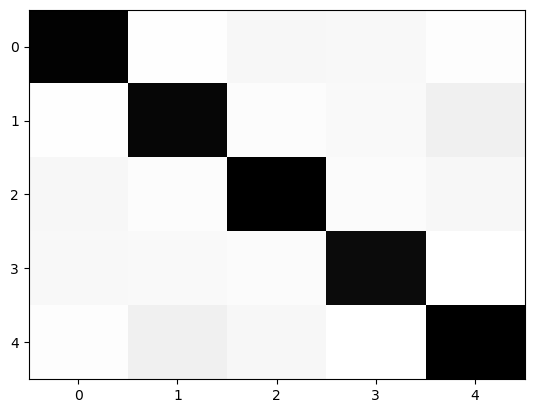

PyObject <matplotlib.image.AxesImage object at 0x23eef3fd0>

In [256]:
PyPlot.figure()
PyPlot.imshow(cov(zs),aspect="auto",cmap="binary")

We dichotomize the data.

In [257]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

5610×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

We set the only hyperparameter of the method, namely the number of genes which we want to select.

In [258]:
nvars = 10

10

## Select variables
We then fit log-linear models in an iterative manner. The provided convenience function returns the G squared statistics for each selected variable during the step-wise model fit, the g squared statistics for all observed and latent variables and the indices of the selected variables.

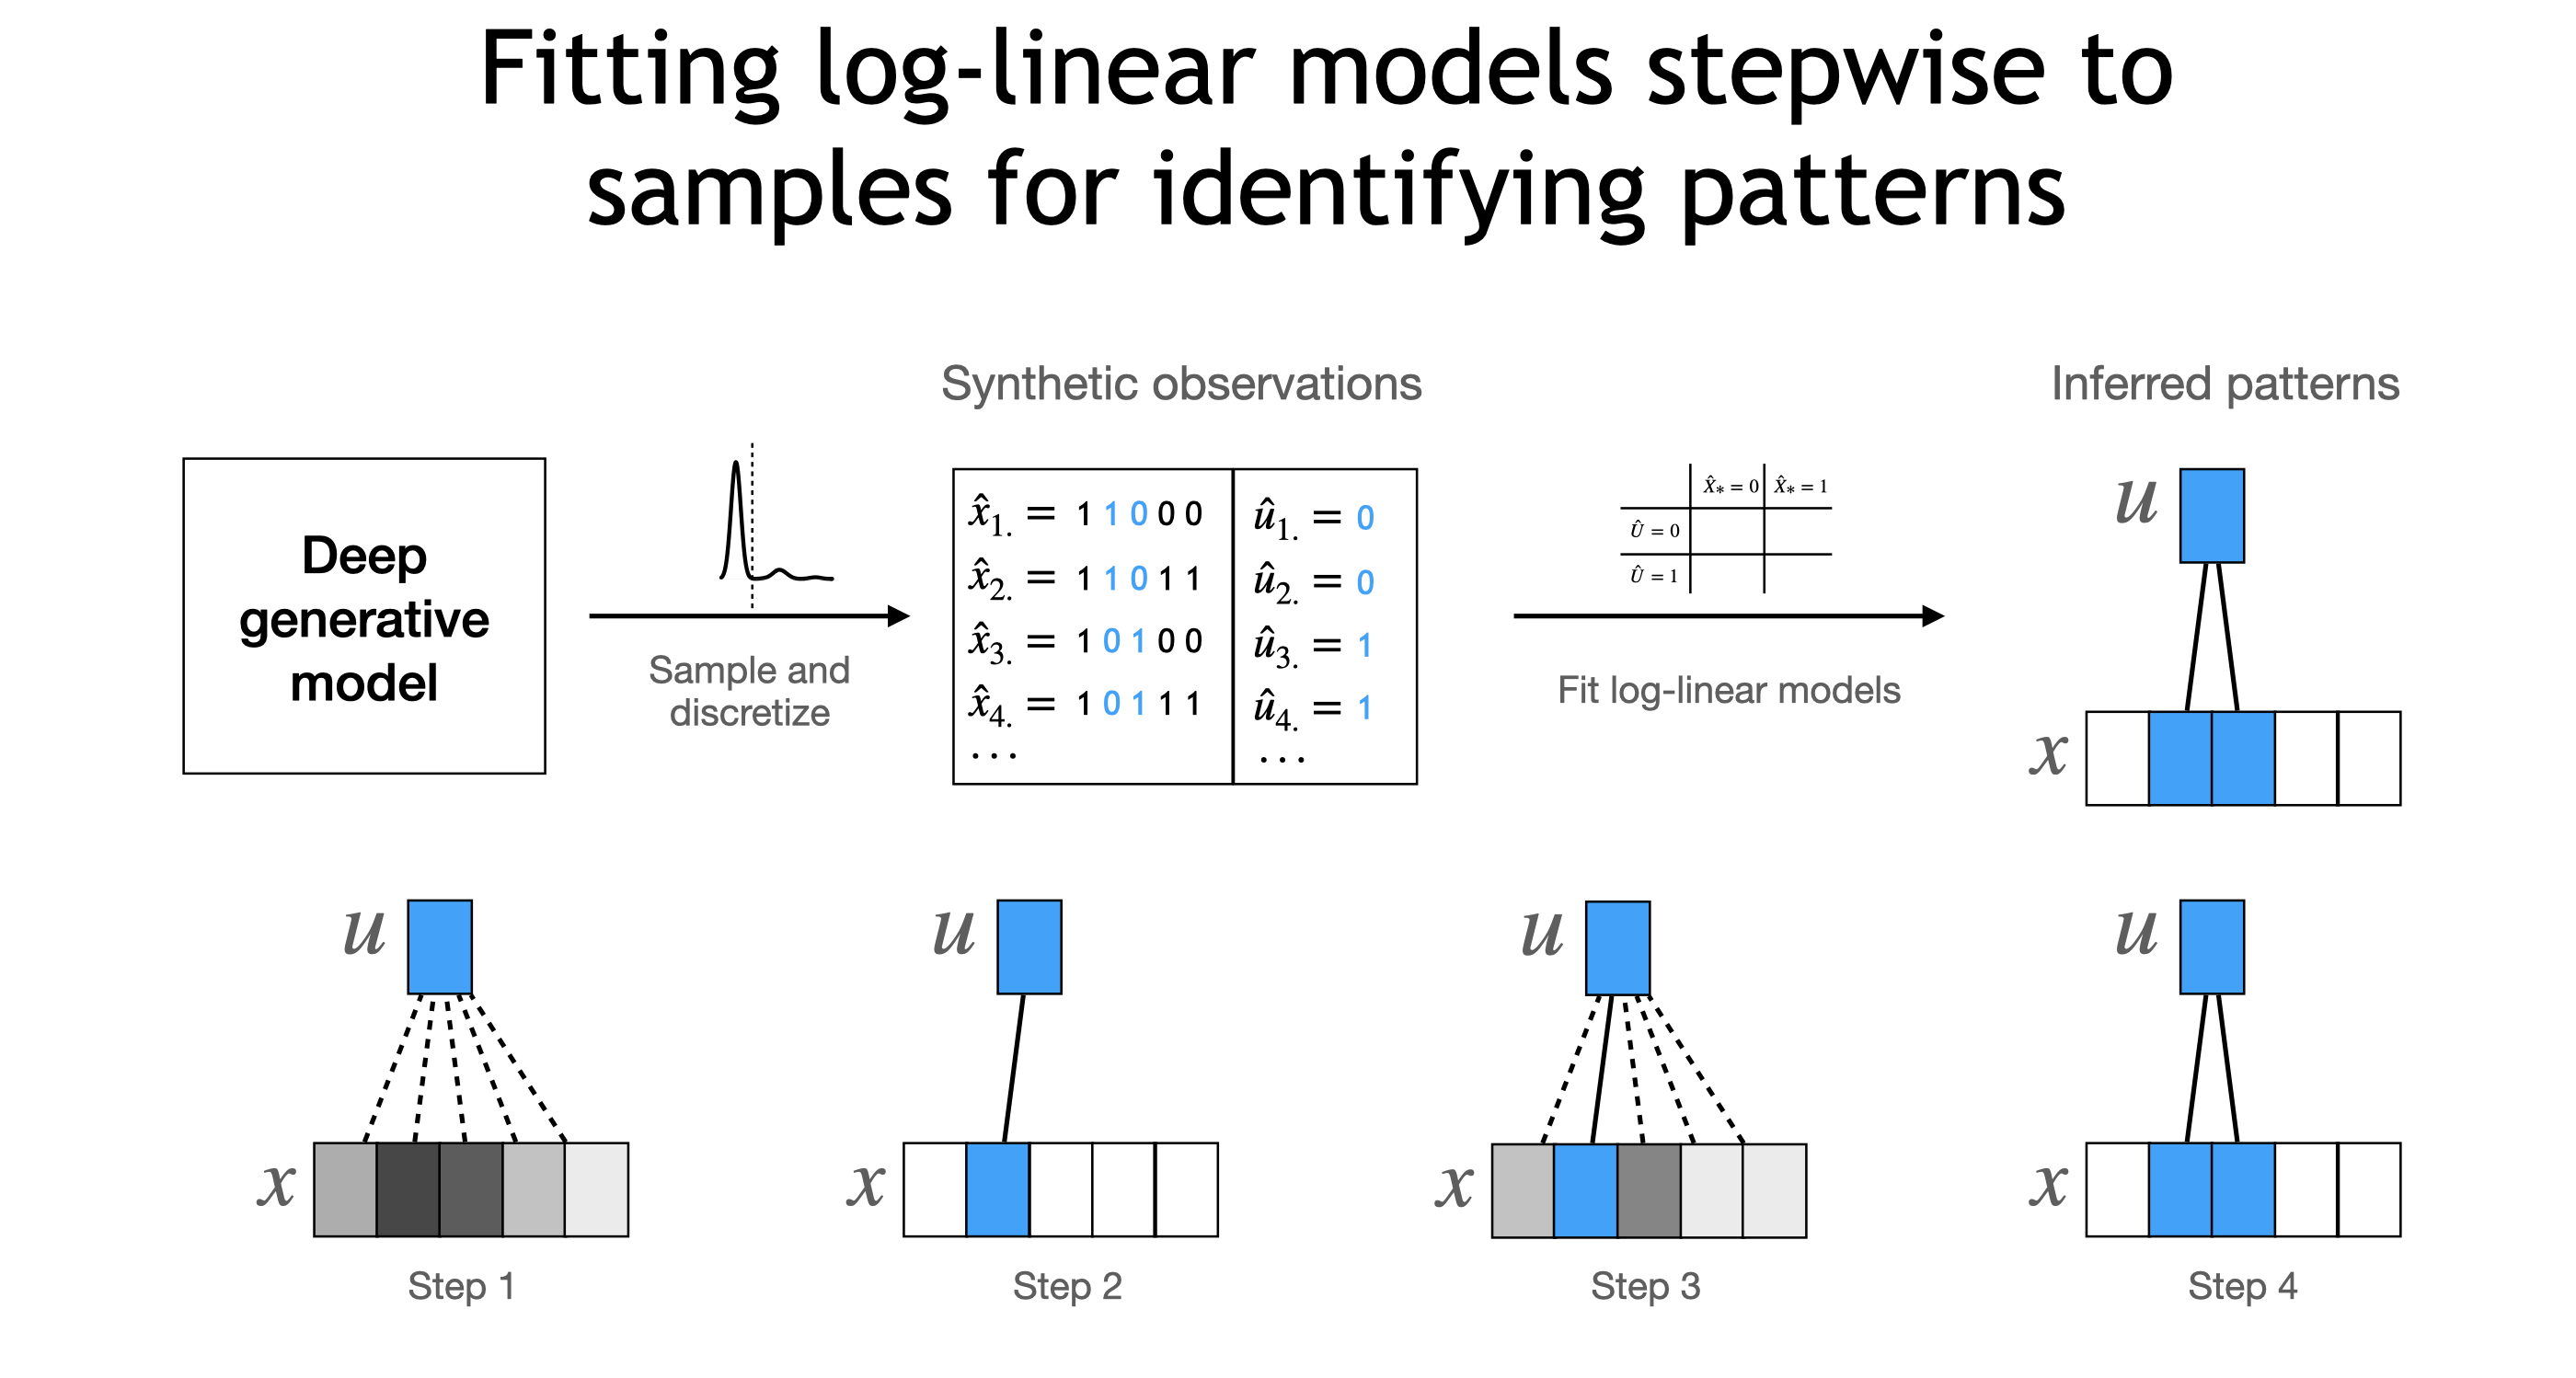

In [259]:
res = extract_pattern(nvars,xsbin,zsbin)

([697.3625711327093, 720.0921491873494, 654.0180564024994, 487.3459335060777, 433.6120550456699, 421.3987400491571, 347.92569944436667, 317.7287004093069, 341.11041206527347, 319.1647924765539], [163, 133, 48, 177, 53, 157, 109, 76, 152, 20], Any[[157.4964357518513 213.22875562356614 … 129.5824611305409 119.21992937448778; 218.86736199164096 98.91755597663146 … 1.1199586985903096 11.183407396551772; … ; 141.37458948595747 16.330183366092847 … 10.981188267055018 9.720827780093103; 2.386933618638089 14.886687049298104 … 0.6211433800358712 0.33104075483551654], [142.57948388755506 200.21953042893588 … 119.98045786171059 85.93936650593032; 214.49443318488835 96.13923647775303 … 6.289864262370314 18.931886390832855; … ; 147.87568783182758 15.446867329267349 … 10.54063653380717 7.686854698318662; 7.328468731586543 15.899242015532689 … 0.4662512483094815 1.1735900115612516], [102.6685280496351 203.79743584896968 … 119.5717153794737 101.20601279501078; 166.5274360066225 121.30425561188858 … 6.

We inspect the g squared statistics for the selected 8 variables.

In [260]:
res[1]

10-element Vector{Float64}:
 697.3625711327093
 720.0921491873494
 654.0180564024994
 487.3459335060777
 433.6120550456699
 421.3987400491571
 347.92569944436667
 317.7287004093069
 341.11041206527347
 319.1647924765539

## Inspect the G-Squared matrix for each selected variable
The Matrices indicate the G-Squared statistic used for selecting a variable at a given iteration (here 9 iterations evaluated).
In the below stated example, g-squared matrices for iteration 1-9 (based on which the 1st to 9th variable are selected) are shown. In the first plot, we only inspect statistics for the finally selected variables, while in the second plot, we investigate a clustered view (only genes are clustered) on all genes and latent variables.

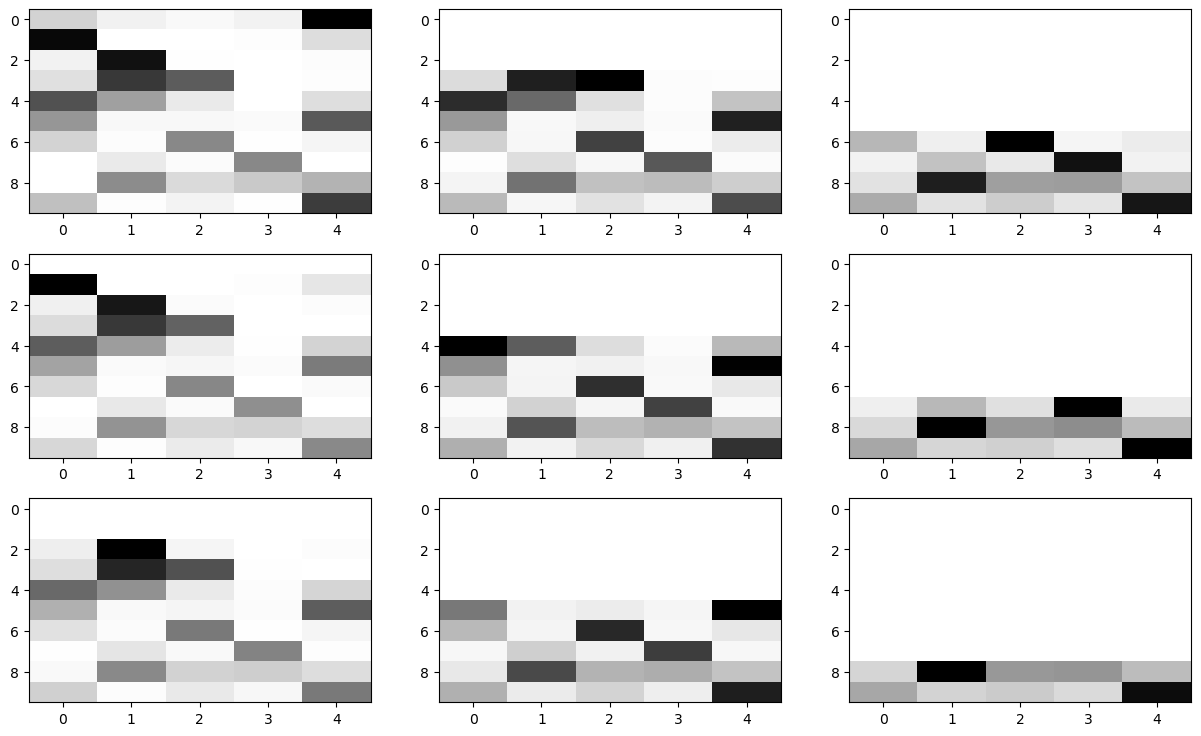

PyObject <matplotlib.image.AxesImage object at 0x2416a3ca0>

In [286]:
PyPlot.figure()
fig, ax = subplots(nrows=3, ncols=3, figsize=(15, 9))
ax[1].imshow(res[3][1][res[2],:],aspect="auto",cmap="binary")
ax[2].imshow(res[3][2][res[2],:],aspect="auto",cmap="binary")
ax[3].imshow(res[3][3][res[2],:],aspect="auto",cmap="binary")
ax[4].imshow(res[3][4][res[2],:],aspect="auto",cmap="binary")
ax[5].imshow(res[3][5][res[2],:],aspect="auto",cmap="binary")
ax[6].imshow(res[3][6][res[2],:],aspect="auto",cmap="binary")
ax[7].imshow(res[3][7][res[2],:],aspect="auto",cmap="binary")
ax[8].imshow(res[3][8][res[2],:],aspect="auto",cmap="binary")
ax[9].imshow(res[3][9][res[2],:],aspect="auto",cmap="binary")
# ax = PyPlot.imshow(res[3][1][res[2],:],aspect="auto",cmap="binary")

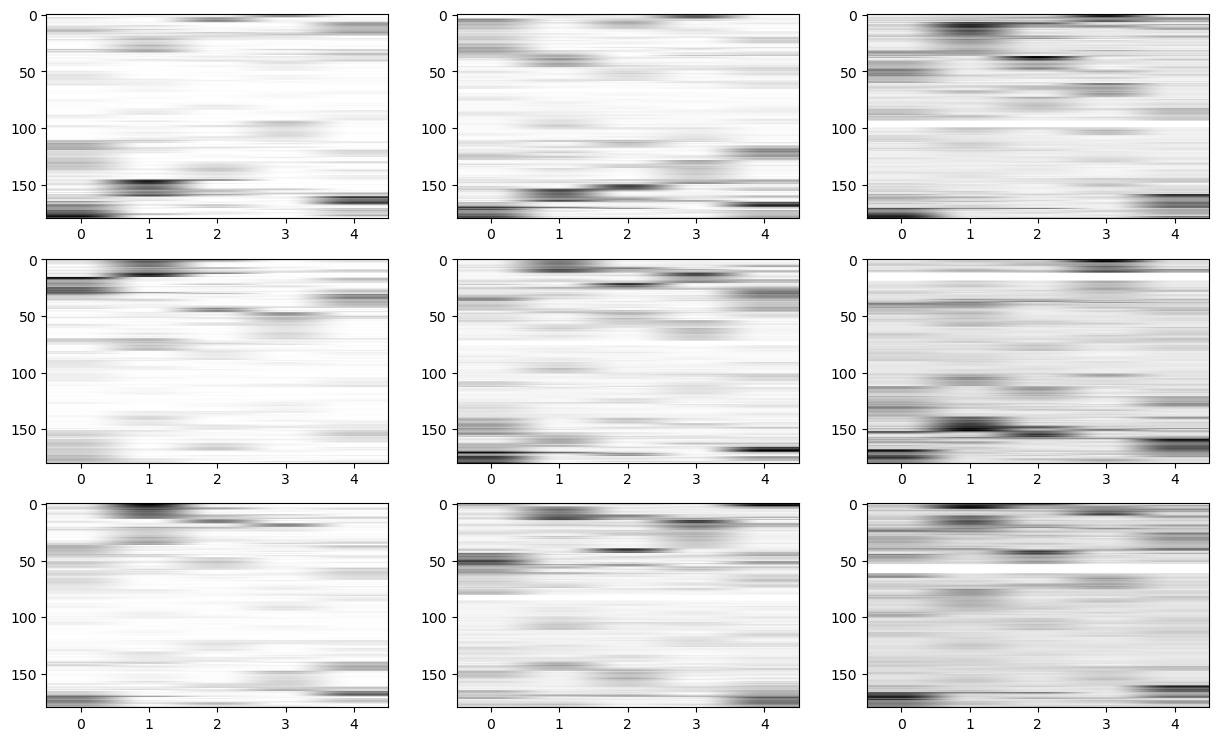

PyObject <matplotlib.image.AxesImage object at 0x242d79c40>

In [294]:
PyPlot.figure()
fig, ax = subplots(nrows=3, ncols=3, figsize=(15, 9))
ax[1].imshow(cluster_matrix(res[3][1],clusterp=false)[5],aspect="auto",cmap="binary")
ax[2].imshow(cluster_matrix(res[3][2],clusterp=false)[5],aspect="auto",cmap="binary")
ax[3].imshow(cluster_matrix(res[3][3],clusterp=false)[5],aspect="auto",cmap="binary")
ax[4].imshow(cluster_matrix(res[3][4],clusterp=false)[5],aspect="auto",cmap="binary")
ax[5].imshow(cluster_matrix(res[3][5],clusterp=false)[5],aspect="auto",cmap="binary")
ax[6].imshow(cluster_matrix(res[3][6],clusterp=false)[5],aspect="auto",cmap="binary")
ax[7].imshow(cluster_matrix(res[3][7],clusterp=false)[5],aspect="auto",cmap="binary")
ax[8].imshow(cluster_matrix(res[3][8],clusterp=false)[5],aspect="auto",cmap="binary")
ax[9].imshow(cluster_matrix(res[3][9],clusterp=false)[5],aspect="auto",cmap="binary")
# ax = PyPlot.imshow(res[3][1],aspect="auto",cmap="binary")

## Annotate synthetic observations

Based on patterns in the selected 8 variables, we then assign a real expression vector to the samples drawn from the prior distribution.

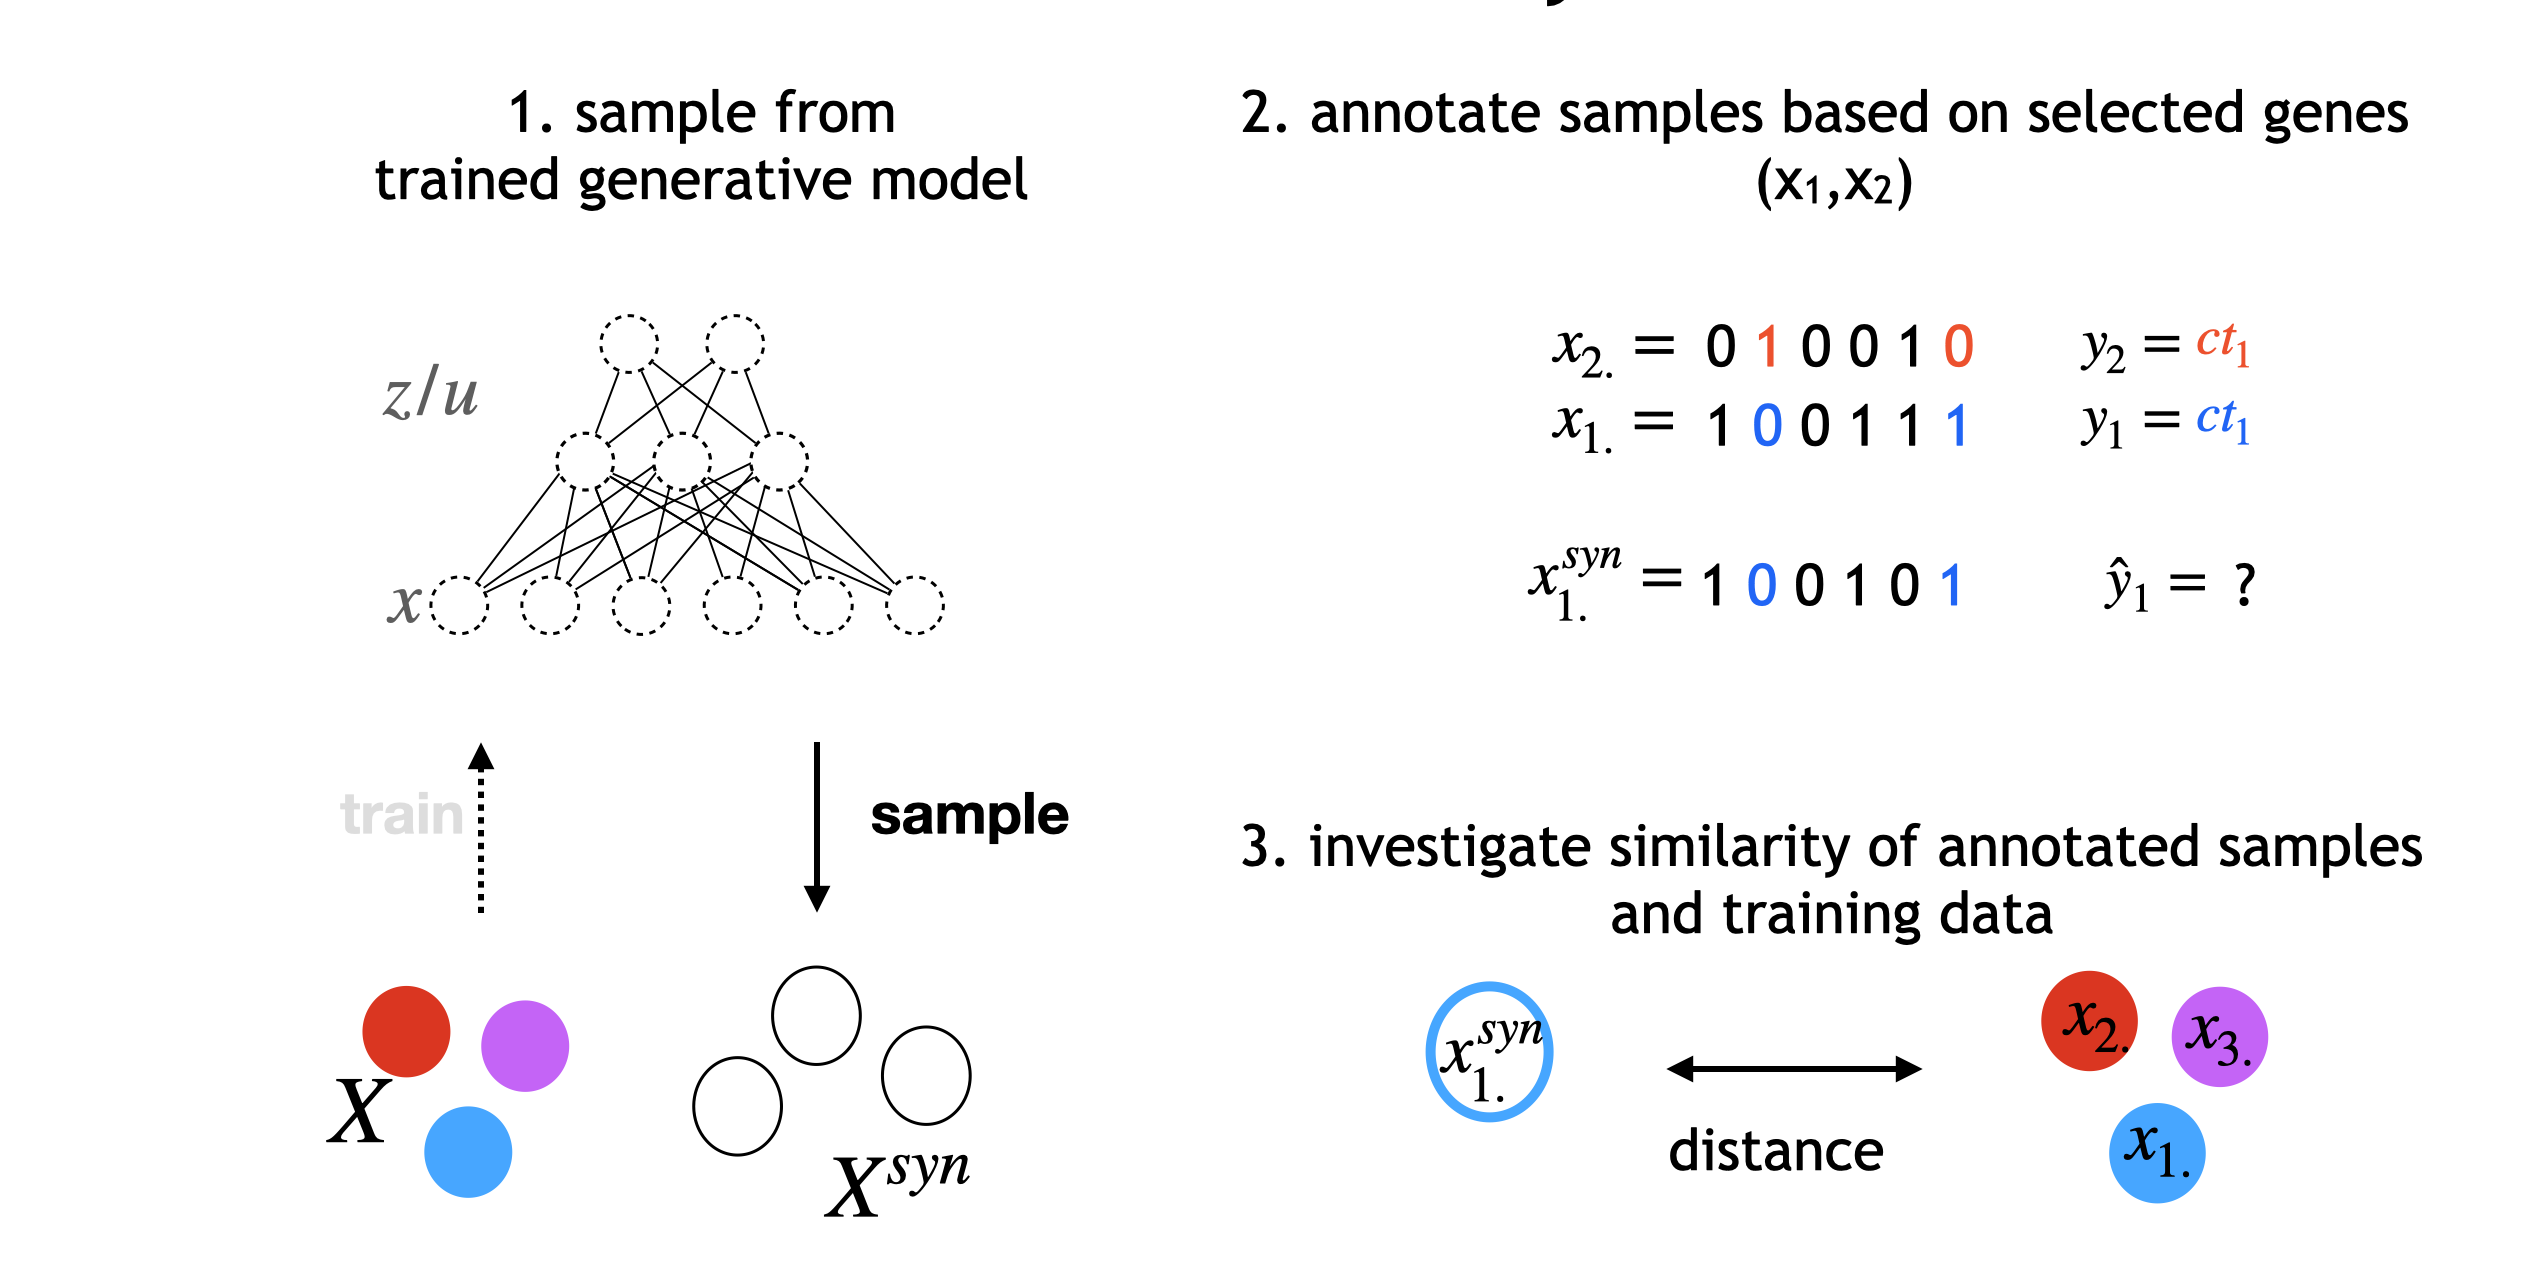

In [262]:
yhat = annotatesamplesbypattern(x01,xsbin[1:1000,:],res[2],y)

1000-element Vector{String}:
 "Sst"
 "L2/3"
 "Vip"
 "Vip"
 "Vip"
 "L2"
 "Sst"
 "Vip"
 "L4"
 "Vip"
 "Sst"
 "Vip"
 "Vip"
 ⋮
 "Vip"
 "Vip"
 "L2"
 "Pvalb"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Sst"
 "Vip"
 "Vip"

Compute principal components of synthetic data for plotting

In [263]:
pcs = prcomps(xsbin[1:1000,:])[:,1:2]

1000×2 Matrix{Float64}:
  1.97654   -0.263701
 -1.4419    -1.35684
 -1.87294    0.730141
 -0.942042   2.03865
  1.3475     5.52059
 -1.72309   -0.599271
  2.61194    0.846027
 -1.09265    1.31397
  1.24609   -0.351034
 -1.34151    1.33842
  1.40363   -0.507893
  0.527575  -3.43981
 -4.78043    2.13347
  ⋮         
 -0.971392  -0.346828
  0.260206   1.41925
 -3.09448   -3.75061
  2.72385   -0.734576
  0.56988    0.906836
 -1.929     -0.399698
  0.82862    0.167411
 -0.373379  -3.23644
 -2.53629    0.606708
  2.75161   -0.574642
  0.280829   1.55095
  3.10452   -4.02601

Here we map the cell labels to colors for plotting.

In [264]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "green",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "green"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

First, we assign colors to the label of real expression vectors.

In [265]:
cols = [md[i] for i = y]

1525-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "turquoise"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "green"
 "lightgrey"
 "turquoise"
 "green"
 "orangered"
 "lightgrey"
 "darkviolet"
 ⋮
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"

Then, we assign colors to the label of samples.

In [266]:
hatcols = [md[i] for i = yhat]

1000-element Vector{String}:
 "gold"
 "lightgrey"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "green"
 "gold"
 "darkviolet"
 "turquoise"
 "darkviolet"
 "gold"
 "darkviolet"
 "darkviolet"
 ⋮
 "darkviolet"
 "darkviolet"
 "green"
 "orangered"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "gold"
 "darkviolet"
 "darkviolet"

And finally we plot the first two PCs of the synthetic data sampled from a VAE, colored by the inferred labels using the log-linear models.

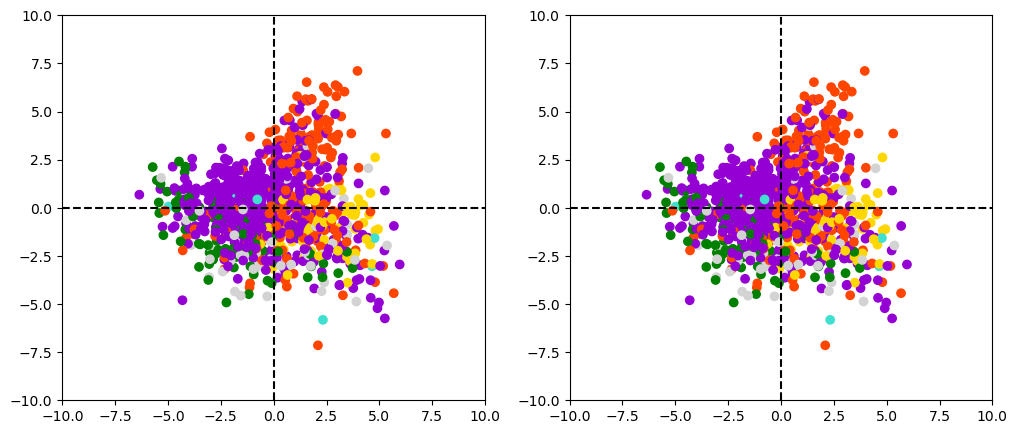

PyObject <matplotlib.lines.Line2D object at 0x23f733850>

In [267]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

Plotting separately for individual cell types

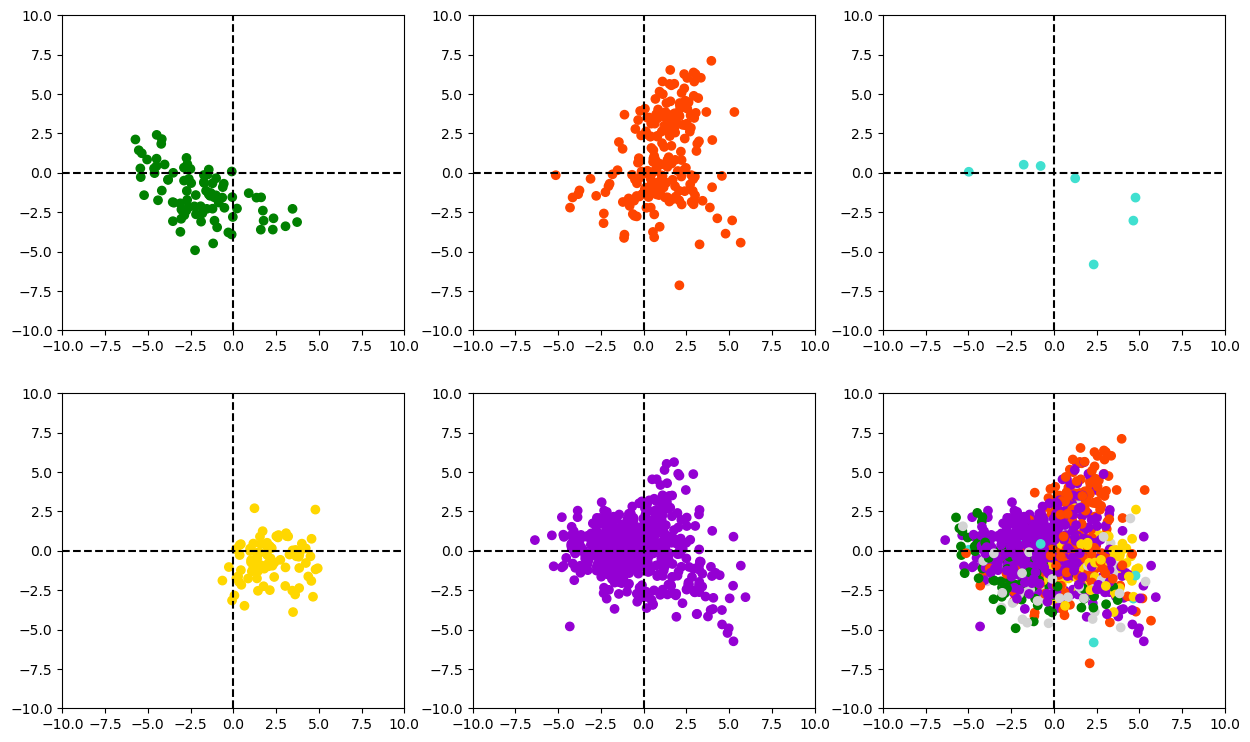

PyObject <matplotlib.lines.Line2D object at 0x23f93e1c0>

In [268]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 10
ax[1].scatter(pcs[hatcols.=="green",1],pcs[hatcols.=="green",2],c=hatcols[hatcols.=="green"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pcs[hatcols.=="gold",1],pcs[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pcs[hatcols.=="orangered",1],pcs[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pcs[hatcols.=="darkviolet",1],pcs[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(pcs[hatcols.=="turquoise",1],pcs[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")

We then investigate the expression matrix for the selected genes

In [205]:
selmat = zscores(log.(x[:,res[2]].+1))

1525×10 Matrix{Float64}:
  1.35322    3.69229    -0.580804  …  -0.25569    1.02532    -0.305531
  1.17134    0.0279246  -0.580804     -0.25569   -0.20572    -0.305531
 -1.4277    -0.36201    -0.580804     -0.25569    0.61799    -0.305531
  0.861667  -0.36201    -0.580804     -0.25569    0.328178   -0.305531
  1.05345   -0.198854   -0.580804     -0.25569   -0.0738942  -0.305531
  0.491873  -0.196175   -0.580804  …  -0.25569    0.721348   -0.305531
  0.605821  -0.36201    -0.580804     -0.25569    0.335519   -0.305531
  0.343828  -0.36201    -0.580804     -0.25569    0.367561   -0.305531
  0.11782   -0.36201    -0.580804     -0.25569    0.194375   -0.305531
  0.366034  -0.36201    -0.468014     -0.25569    0.313917   -0.305531
  0.309217  -0.36201    -0.580804  …  -0.25569    0.150107   -0.305531
  0.64473   -0.36201    -0.580804     -0.25569    0.103212   -0.305531
  0.7174    -0.36201    -0.441667     -0.25569    0.299556   -0.305531
  ⋮                                ⋱                

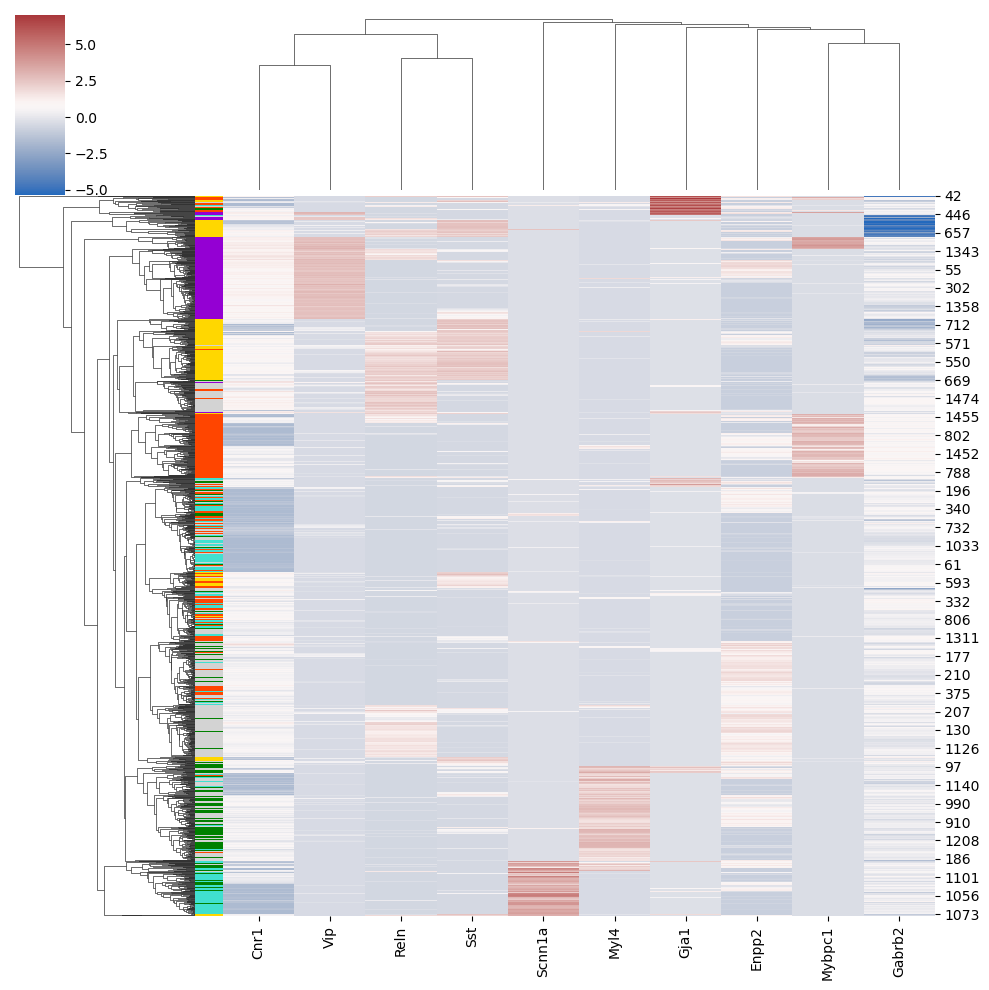

PyObject <seaborn.matrix.ClusterGrid object at 0x23e941d30>

In [206]:
Seaborn.clustermap(selmat,row_colors=[md[i] for i = y],cmap="vlag",xticklabels=genenames[res[2]])

## Extracting patterns from scVAEs (zero inflated negative binomial distributions)
For sc-RNASeq data, there are adaptations that can handle (zero inflated) negative binomially distributed data (scVAE, such as scVI). Here we will demonstrate how to employ the log-linear models for extracting patterns from synthetic data sampled from an scVAE.

In [207]:
a1 = AnnData()

AnnData object with a countmatrix with nothing cells and nothing genes


In [208]:
a1.countmatrix = convert(Matrix{Float32},x)

1525×180 Matrix{Float32}:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                                  ⋱                   

In [209]:
a1.ngenes = size(x)[2]
a1.ncells = size(x)[1]

1525

First we load the expression matrix and filter to get the same genes as used for fitting the VAE for Bernoulli distributed data.

In [210]:
# a1 = scVI.load_tasic("data/")

In [211]:
# subset_tasic!(a1)

We then calculate the library size factors. In a scVAE these are important because the normalizing effect of dichotomization used for the Bernoulli VAE is not employed here.

In [212]:
# calculate library size 
library_log_means, library_log_vars = init_library_size(a1)

([11.104060173034668], [0.3126426935195923])

We then initialize the scVAE and train it on the data from Tasic et al. (2016).

In [213]:
# initialise scVAE model 
n_zs = 5
m = scVAE(size(a1.countmatrix,2);
        n_layers=1,
        library_log_means=library_log_means,
        library_log_vars=library_log_vars,
    n_hidden=70,
    n_batch=10,
    n_latent=n_zs,
    gene_likelihood=:zinb
)

# train model
training_args = TrainingArgs(
    max_epochs=50, # 50 for 10-dim 
    weight_decay=Float32(1e-6),
)
train_model!(m, a1, training_args)

#plot UMAP of latent representation 
#plot_umap_on_latent(m, a1; save_plot=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/moritz/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
  loss:  469.94376
┌ Info: training complete!
└ @ scVI /Users/moritz/.julia/packages/scVI/1h1jd/src/Training.jl:93


(scVAE(180, 10, 70, 5, 1, :gene, 0.1f0, true, :zinb, :normal, true, Dict{Any, Any}(), true, scEncoder(Chain(Dense(180 => 70), BatchNorm(70), identity, #39, Dropout(0.1)), Dense(70 => 5), 180, 5, 70, 1, exp, Dense(70 => 5), 0.0001f0, identity), nothing, scDecoder(5, 70, 180, 1, Chain(Dense(5 => 70), BatchNorm(70), identity, #39, Dropout(0.1)), Dense(70 => 180), Float32[-1.0417286, 0.42213398, 1.0564992, -0.95481837, 0.088506505, 1.6597656, -0.95668644, 0.36583093, -1.2426776, -0.307032  …  -0.3548887, -0.77584934, -0.13312477, -1.89544, -0.28568026, 0.43016335, 0.09570655, -0.52572626, -0.93640137, 0.71986634], Chain(Dense(70 => 180), #57), true, false)), AnnData object with a countmatrix with 1525 cells and 180 genes
)

In [214]:
x1 = a1.countmatrix

1525×180 Matrix{Float32}:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                                  ⋱                   

Here we infer the states of the latent variables (z), based on the observed gene expression data. This is equivalent to draw from the posterior distribution of the latent variables.

In [215]:
infres = scVI.inference(m,Transpose(x1))

(Float32[-3.8217416 -2.2753942 … -2.8214908 -3.3698409; 3.259824 3.814917 … 0.19421929 1.1557368; … ; -4.679905 -2.0507276 … -2.3449962 -3.0270298; 1.3885031 -0.41742626 … 1.7167611 0.7323773], Float32[-3.751556 -2.4106798 … -2.6759446 -3.5790079; 3.2160664 3.6239028 … 1.0243808 1.0394685; … ; -4.700964 -2.2374444 … -2.3793664 -3.2320356; 1.4986935 -0.5078412 … 1.7409799 0.53493845], Float32[0.009678321 0.018791618 … 0.02252598 0.01942163; 0.030701412 0.04374477 … 0.35351178 0.14788519; … ; 0.023759695 0.032858897 … 0.032137856 0.11531186; 0.05783679 0.042044554 … 0.088539235 0.02866161], nothing, nothing, Float32[12.59725 11.704754 … 11.649896 11.77221])

In [216]:
infres[1]

5×1525 Matrix{Float32}:
 -3.82174  -2.27539    1.53994  -2.68103   …  -2.81838   -2.82149   -3.36984
  3.25982   3.81492   -2.2864    3.4467        0.363111   0.194219   1.15574
 -1.13296  -1.18684   -3.34612   0.396205     -0.166026   1.66006    1.3138
 -4.6799   -2.05073    0.57711  -4.09726      -2.43504   -2.345     -3.02703
  1.3885   -0.417426  -2.49333  -0.481391      1.63585    1.71676    0.732377

We inspect the covariance of the latent variables.

In [217]:
covz = cov(Transpose(infres[1]))

5×5 Matrix{Float32}:
  4.26978   -0.602372  -0.706265   1.75054   0.649193
 -0.602372   7.45429    1.54605   -2.11487   2.33849
 -0.706265   1.54605    5.43796   -1.271     2.30713
  1.75054   -2.11487   -1.271      3.93089  -1.10334
  0.649193   2.33849    2.30713   -1.10334   4.27065

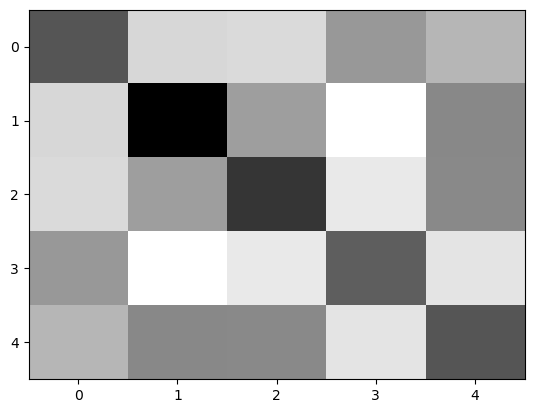

PyObject <matplotlib.image.AxesImage object at 0x23e634af0>

In [218]:
PyPlot.figure()
PyPlot.imshow(cov(Transpose(infres[1])),aspect="auto",cmap="binary")

Alternatively we can draw from the prior distribution, which is basically sampling from a multivariate normal distribution.

In [219]:
normdist = rand(MultivariateNormal(fill(0,size(covz)[1]),covz),10000)

5×10000 Matrix{Float32}:
 0.445406  -0.867378  3.3384    0.795065  …  -0.476473  -3.47139  -0.316829
 0.554455  -0.71414   3.50603  -2.33651      -1.01205    2.09689   0.214243
 0.330773   1.37404   2.38519   0.401946     -1.22065    2.12989   0.851529
 0.426792   5.2677    0.30075   1.08016      -1.94072   -2.84292   0.648675
 1.02197    1.89756   1.69773   0.727983     -2.34026    2.33057   0.230123

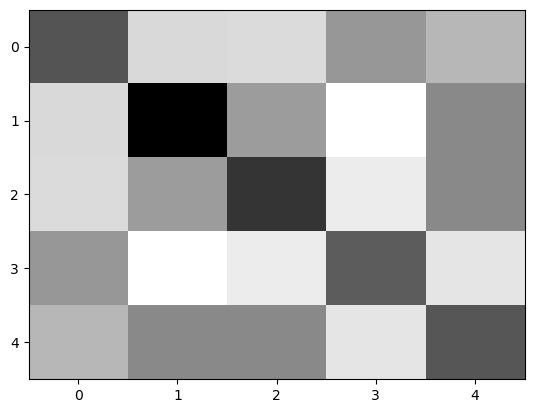

PyObject <matplotlib.image.AxesImage object at 0x23ed414f0>

In [220]:
PyPlot.figure()
PyPlot.imshow(cov(Transpose(normdist)),aspect="auto",cmap="binary")

For sampling from a negative binomial distribution, we need the library size, which is essentially a scaling factor.

In [221]:
libsize = sum(x1,dims=2)

1525×1 Matrix{Float32}:
 295744.1
 121146.22
  81335.984
 169927.66
 154057.33
  84935.65
  79330.07
  73362.26
  35174.527
  71338.31
  42179.902
  49352.33
 140304.02
      ⋮
  59410.133
  66530.61
  36251.2
  56015.723
  43128.215
  67526.836
 146509.1
 115469.57
 105664.9
 128478.92
 114679.414
 129600.21

When we sample from the prior distribution, of course there is no library size available, thus we inspect the distribution of the library sizes in the Tasic et al. data and then sample from a normal distribution with similar expected value and standard deviation.

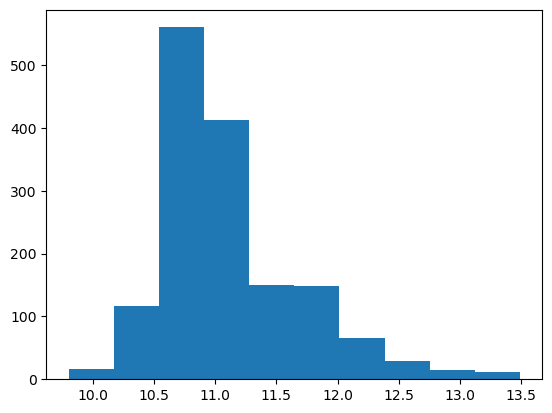

([16.0, 117.0, 560.0, 413.0, 150.0, 149.0, 66.0, 29.0, 14.0, 11.0], Float32[9.803326, 10.172036, 10.540746, 10.909456, 11.278166, 11.646876, 12.015587, 12.384296, 12.753007, 13.1217165, 13.490427], (PyObject <matplotlib.patches.Rectangle object at 0x239b816d0>, PyObject <matplotlib.patches.Rectangle object at 0x239d44f40>, PyObject <matplotlib.patches.Rectangle object at 0x23ed74eb0>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89100>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89310>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89520>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89730>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89940>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89b50>, PyObject <matplotlib.patches.Rectangle object at 0x23ed89d60>))

In [222]:
PyPlot.figure()
PyPlot.hist(log.(libsize))

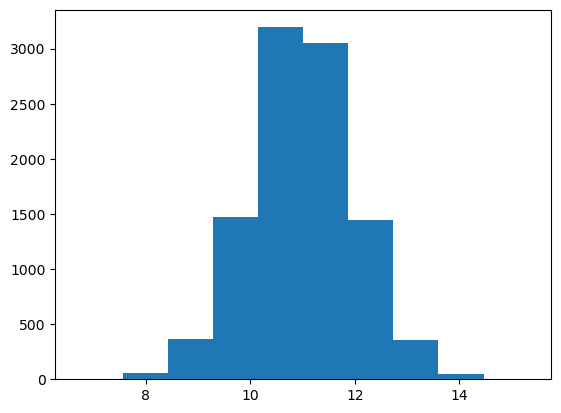

([4.0, 59.0, 366.0, 1468.0, 3194.0, 3050.0, 1446.0, 359.0, 48.0, 6.0], [6.703844793717037, 7.565692299362985, 8.427539805008934, 9.289387310654881, 10.151234816300828, 11.013082321946776, 11.874929827592725, 12.736777333238672, 13.598624838884621, 14.460472344530569, 15.322319850176516], (PyObject <matplotlib.patches.Rectangle object at 0x23edcadf0>, PyObject <matplotlib.patches.Rectangle object at 0x23edcac70>, PyObject <matplotlib.patches.Rectangle object at 0x23edd62e0>, PyObject <matplotlib.patches.Rectangle object at 0x23edd64f0>, PyObject <matplotlib.patches.Rectangle object at 0x23edd6700>, PyObject <matplotlib.patches.Rectangle object at 0x23edd6910>, PyObject <matplotlib.patches.Rectangle object at 0x23edd6b20>, PyObject <matplotlib.patches.Rectangle object at 0x23edd6d30>, PyObject <matplotlib.patches.Rectangle object at 0x23edd6f40>, PyObject <matplotlib.patches.Rectangle object at 0x23ede1190>))

In [223]:
PyPlot.figure()
PyPlot.hist(rand(Distributions.Normal(11,1),10000))

If we sample the observed variables based on the prior distribution of the latent variables, we assume an arbitrary value for the scaling factor, which we draw from a Normal Distribution with expected value of 11 and standard deviation 1.

In [224]:
res2 = scVI.decodersample(m,normdist,convert(Matrix{Float32},Transpose(rand(Distributions.Normal(11,1),10000))))

180×10000 Matrix{Int64}:
  11  287    0  79  133  2340   0  1214  …     0    0     0  2005     0   10
  34    0   39   0    0     0  43     0      952  120     0   217     0    0
  22    0    0  10    0    42  14    23      340    0   494   346    72    0
   0    0    0  22    0     0   0     0        0    0     0     0     0    0
   0    0    0   0    0     0   0     0        0    0     0     0     0   10
   0    0   38  46    0   141   0     0  …     0   21     0     0     0    0
   0    0    0   0    0     0   0     0        0    0     0     0     0    0
   0    0    0   0    0     0   0     0       46    0     4   917     0    0
 112    0    0  35    0     1   0   367        0    0    65     0     0    0
   0    0    0   0    0     0   0     0        0    0     0     0     0    0
   0    0  112   0    0     0  31     0  …     0  168     0     0     2   50
   2    0    0   2    0     1   0     1       58    0     0     0     0    0
  72    0    0   0    0     0   0     0        0   

Here we sample the values for the observed variables conditional on a draw from the posterior distribution.

In [225]:
res3 = scVI.decodersample(m,infres[1],Transpose(log.(libsize)))

180×1525 Matrix{Int64}:
     0    0  173      0       0  138  …      0     0     0      0    0     0
     0    0  147    406     351    0        88     0     0    528    0     0
   596  384    7    133      87   24        44   246   147    349   38     0
     0    0    0      0       0    0         0     0     0      0    0     0
     0    0    0      0       0    0         0     0  1129    115    0     0
    46    0    0      0       0   39  …      0    56     0     45    0     0
     0    0    0      0       0    0         0     0     0      0    0     0
     0    2    0      0       0    4         0     2    94      2    0     0
   124  341  295      0       0    5         0     8     0      0  126     0
     0    0    0      0       0    0         0     0     0      0    0     0
     0   93    0     21       0    0  …      0     0    57      0  260    61
     0    0    0      0       0    0         0     0     0      0    0     0
     0    0    0      0       0    0         0     0

In order to investigate the quality of the learnt distribution, we can compare the covariance matrix computed from the sampled synthetic observations with the covariance matrix computed from the original data.

In [226]:
cmats=cov(Transpose(log.(res3.+1)))

180×180 Matrix{Float64}:
  8.51679    -2.0106      -2.25858    …  -0.112311     -0.0391871
 -2.0106      6.03075      0.788907       0.213755      0.0312024
 -2.25858     0.788907     4.05343        0.0730267    -0.0241605
  0.583404   -0.367335    -0.358597      -0.00215763    0.00554552
  0.0645314  -0.215994     0.0942656     -0.00498871   -0.0221862
  1.01742    -0.53724     -0.723754   …   0.0318748     0.00318799
  0.0396103  -0.0355479   -0.0160637     -0.00756952    0.00366604
 -0.0926002   0.0930466    0.153357       0.0362204    -0.00229684
  0.777972   -0.270797    -0.629111       0.00076119    0.0602906
  0.177027   -0.0613188   -0.0363398     -0.0170173    -0.00917772
 -0.746516    0.839568     0.171849   …   0.055865      0.0609154
  0.0415497  -0.111905    -0.0265155     -0.000418762  -0.0111272
  0.0596587   0.0294684    0.0123518      0.0273918     0.0220248
  ⋮                                   ⋱                
 -0.579817    0.364111     0.462155      -0.0237777    -

In [227]:
cmat = cov(log.(x1.+ 1))

180×180 Matrix{Float32}:
  9.74901    -2.30395     -2.36882     …  -0.0550508     0.0224171
 -2.30395     5.17761      0.821996        0.23014       0.0559934
 -2.36882     0.821996     3.54817        -0.0622513     0.0119462
  0.867629   -0.246475    -0.376976       -7.90805f-5    0.0123659
  0.367547   -0.17832      0.0765757      -0.0480148    -0.0140216
  1.23876    -0.428879    -0.454277    …   0.0215122     0.0593106
  0.0478442  -0.0345746   -0.0217872      -0.00570485   -0.00232604
 -0.209837    0.134364     0.0629303       0.0249866     0.0323814
  0.98618     0.0654653   -0.457241        0.136795     -0.00806783
  0.180902   -0.0925702   -0.0762379      -0.0138768     0.00861435
 -1.11035     1.08158      0.220494    …   0.175086      0.0712893
  0.0793958  -0.0473672   -0.00682154     -0.0126866     0.0257686
 -0.0697931   0.107343     0.00637307      0.0294069     0.000516367
  ⋮                                    ⋱                
 -0.845961    0.134045     0.503138       

In [228]:
order = cluster_matrix(cmat)[4]

180-element Vector{Int64}:
  20
 163
  37
 177
  15
 147
 155
   1
 101
  17
  64
  68
 100
   ⋮
 108
  51
  83
  89
 143
 150
  71
  63
  66
  53
  65
  85

Here we investigate the corresponding matrices which are oriented according to the clustering of the genes in the original data used for training.

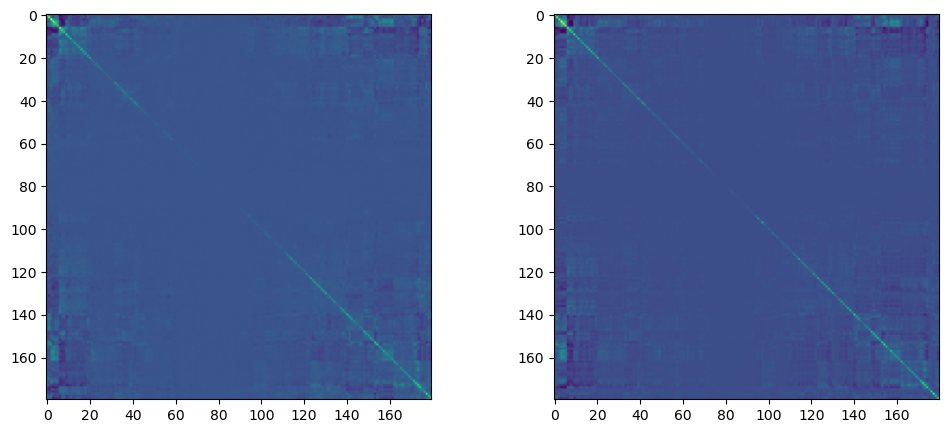

PyObject <matplotlib.image.AxesImage object at 0x23ee677f0>

In [229]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].imshow(cmat[order,order])
ax[2].imshow(cmats[order,order])

We format the samples drawn from the scVAE.

In [230]:
zs = float.(Transpose(infres[1]))
#zs = Transpose(normdist)
xs = float.(Transpose(res3))

1525×180 Matrix{Float64}:
    0.0    0.0  596.0  0.0     0.0  …   0.0   48588.0  0.0    0.0    0.0
    0.0    0.0  384.0  0.0     0.0      0.0     612.0  0.0    0.0    0.0
  173.0  147.0    7.0  0.0     0.0      0.0      21.0  0.0    0.0    0.0
    0.0  406.0  133.0  0.0     0.0      0.0   44117.0  0.0    0.0    0.0
    0.0  351.0   87.0  0.0     0.0      0.0  111426.0  0.0    0.0    0.0
  138.0    0.0   24.0  0.0     0.0  …   0.0       0.0  0.0    0.0    0.0
    0.0    0.0   12.0  0.0     0.0      0.0       0.0  0.0    0.0    0.0
  468.0    0.0    0.0  5.0     0.0      0.0       0.0  0.0    0.0    1.0
  195.0    0.0    0.0  1.0     0.0     61.0       0.0  0.0    0.0    0.0
 2729.0   49.0    0.0  0.0   205.0      0.0       0.0  0.0    0.0    0.0
  882.0   74.0    0.0  0.0     0.0  …   0.0       0.0  0.0    0.0    0.0
  338.0    0.0   14.0  0.0     0.0      0.0       0.0  0.0    0.0    0.0
    0.0    0.0  183.0  0.0     0.0      0.0    3778.0  0.0    0.0    0.0
    ⋮                    

We then binarize the synthetic observations, here in contrast to the Bernoulli VAE we perform the discretization after training.

In [231]:
zsbin = float.(ifelse.(zs.>0,1,0))

1525×5 Matrix{Float64}:
 0.0  1.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0
 0.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0
 1.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0
 ⋮                   
 1.0  1.0  1.0  0.0  1.0
 1.0  1.0  0.0  1.0  1.0
 1.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  0.0  1.0
 0.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0
 0.0  1.0  1.0  0.0  1.0
 0.0  1.0  1.0  0.0  1.0

In [232]:
xsbin = dichotomize(xs,selquantile=0.9)

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.

We inspect the number we obtain a "1" for each gene.

In [233]:
sum(xsbin,dims=1)

1×180 Matrix{Float64}:
 153.0  151.0  152.0  150.0  120.0  151.0  …  20.0  153.0  11.0  54.0  48.0

We now extract the patterns between observed and latent variables from the discretized synthetic observations.

We again set the only hyperparameter which is the number of variables we want to extract

In [234]:
nvars= 10

10

In [235]:
res = extract_pattern(nvars,xsbin,zsbin)

([309.7055949176197, 282.4668351394424, 215.6492119395634, 159.907079988004, 178.90835226681983, 132.8988315410163, 122.88044248693024, 109.00008591792937, 115.40182862986825, 95.40358642848581], [177, 150, 155, 90, 135, 2, 158, 97, 149, 133], Any[[2.870104360861596 122.81778436822047 … 41.09197054516588 21.65266685247093; 22.203440371948915 186.9230492244362 … 72.89976688437804 23.52009137070479; … ; 21.65978051879268 46.98173426437755 … 11.868869462138619 1.7839190578430077; 5.756149071191199 3.170155678507765 … 3.3444127079491768 2.0200037319160398], [3.985089587595433 99.39108894182888 … 28.692556083023405 22.649127001309935; 6.720319973334396 158.02872696967697 … 50.728106399290326 28.2138421144015; … ; 19.394272890609752 57.296431278326786 … 20.190839068080262 1.5855360073003242; 7.368825044986381 4.603201404468218 … 6.764550044232257 5.404869307266048], [5.887199288746256 88.31363844045973 … 26.51469728528928 20.475955575241855; 10.487709710818505 163.1007715327855 … 60.00567965

We inspect the genes we extracted

In [236]:
genenames[res[2]]

10-element Vector{Any}:
 "Vip"
 "Pvalb"
 "Rorb"
 "Grik3"
 "Myl4"
 "Adra1a"
 "Sema3c"
 "Grin3a"
 "Ptgs2"
 "Mybpc1"

We again inspect the expression in the selected genes.

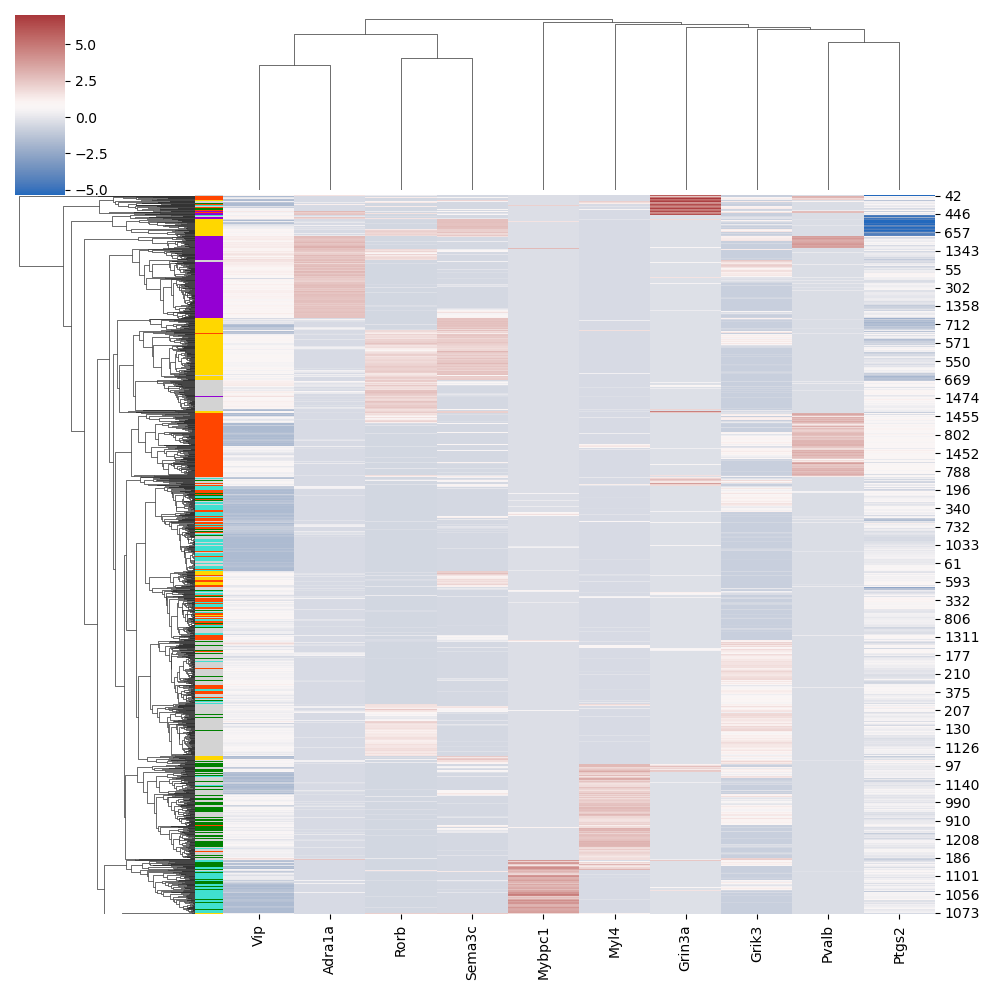

PyObject <seaborn.matrix.ClusterGrid object at 0x23ee4d8e0>

In [237]:
Seaborn.clustermap(selmat,row_colors=[md[i] for i = y],cmap="vlag",xticklabels=genenames[res[2]])

Then we do also annotate synthetic observations with patterns in the extracted genes.

In [238]:
xbin = dichotomize(x1,selquantile=0.9) 

1525×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [239]:
yhat = annotatesamplesbypattern(xbin,xsbin[1:1000,:],res[2],y)

1000-element Vector{String}:
 "Vip"
 "Vip"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"
 "L5"
 ⋮
 "Pvalb"
 "Pvalb"
 "L5a"
 "Pvalb"
 "Pvalb"
 "L5a"
 "Pvalb"
 "Pvalb"
 "L5a"
 "L5a"
 "L5a"
 "L5a"

In [240]:
countmap(yhat)

Dict{String, Int64} with 14 entries:
  "L4"    => 90
  "Vip"   => 278
  "Sst"   => 53
  "L5b"   => 2
  "L5a"   => 69
  "Pvalb" => 459
  "L2"    => 3
  "Smad3" => 1
  "Igtp"  => 3
  "L6b"   => 4
  "L2/3"  => 2
  "L6a"   => 30
  "Ndnf"  => 2
  "L5"    => 4

In [241]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "forestgreen",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "forestgreen"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

In [242]:
hatcols = [md[i] for i = yhat]

1000-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "orangered"
 "orangered"
 "orangered"
 "darkviolet"
 "lightgrey"
 ⋮
 "orangered"
 "orangered"
 "forestgreen"
 "orangered"
 "orangered"
 "forestgreen"
 "orangered"
 "orangered"
 "forestgreen"
 "forestgreen"
 "forestgreen"
 "forestgreen"

In [243]:
countmap(hatcols)

Dict{String, Int64} with 7 entries:
  "lightgrey"   => 48
  "gold"        => 53
  "darkviolet"  => 278
  "forestgreen" => 69
  "green"       => 3
  "orangered"   => 459
  "turquoise"   => 90

In [244]:
pcs = prcomps(Transpose(log.(res3 .+1)))

1525×180 Matrix{Float64}:
 -5.87719   -1.82232    1.76235    …   0.184298  -0.459581    0.736614
 -5.02935    0.879998   3.44664        1.14679    0.308139    1.09276
  2.9389     0.317964   1.13764        0.718786  -0.506939    0.439785
 -6.27086   -3.13978    2.65794       -0.429519  -0.321929    0.166439
 -4.83152   -4.45107    3.44637        1.20951   -1.22674    -0.36396
  0.401262  -2.69298   -1.07979    …  -0.264316   1.1862      0.177503
  1.96546   -1.51779   -1.29739        0.277387   0.0239971   0.0507219
  3.87739   -1.86505    1.24379       -0.368764  -0.427494    0.354514
  3.31752   -0.658702  -1.12094        0.391174   0.454243   -0.252624
  1.66343   -1.17932   -1.62611       -0.472122  -0.543946    0.651092
  0.85442    3.6172     0.242115   …   0.243772  -0.43443     0.553287
  3.16678   -3.1403    -2.84178        0.136862  -0.143236    0.146714
 -6.21563   -3.80621    0.456937       0.9094     1.05424    -1.27296
  ⋮                                ⋱                 

In [245]:
pc1 = pcs[1:1000,:]

1000×180 Matrix{Float64}:
 -5.87719   -1.82232    1.76235   …   0.184298    -0.459581    0.736614
 -5.02935    0.879998   3.44664       1.14679      0.308139    1.09276
  2.9389     0.317964   1.13764       0.718786    -0.506939    0.439785
 -6.27086   -3.13978    2.65794      -0.429519    -0.321929    0.166439
 -4.83152   -4.45107    3.44637       1.20951     -1.22674    -0.36396
  0.401262  -2.69298   -1.07979   …  -0.264316     1.1862      0.177503
  1.96546   -1.51779   -1.29739       0.277387     0.0239971   0.0507219
  3.87739   -1.86505    1.24379      -0.368764    -0.427494    0.354514
  3.31752   -0.658702  -1.12094       0.391174     0.454243   -0.252624
  1.66343   -1.17932   -1.62611      -0.472122    -0.543946    0.651092
  0.85442    3.6172     0.242115  …   0.243772    -0.43443     0.553287
  3.16678   -3.1403    -2.84178       0.136862    -0.143236    0.146714
 -6.21563   -3.80621    0.456937      0.9094       1.05424    -1.27296
  ⋮                               ⋱     

In [246]:
pc2 = prcomps(log.(a1.countmatrix .+1))

1525×180 Matrix{Float32}:
 -7.17064     4.30943    2.6273    …   0.259412   -0.450207    0.411478
 -4.76982     3.24113    2.95963       0.86309    -0.558356   -1.11742
  4.19574     1.87985   -0.550503      0.203376   -0.364234   -0.11371
 -6.12385     2.01034    2.82508       0.283937    0.295076   -0.0831489
 -4.73361     4.35474    0.385151     -0.234467    1.43586    -0.401565
  2.86774     1.32854   -0.674349  …   0.14303    -0.387307   -0.271185
  1.25634     0.497637  -0.715663      0.310112    0.0725875  -0.0752082
  4.94999     1.68719    0.212023     -0.0484311  -0.454667   -0.0879959
  2.52716     1.41128   -0.175875      0.202563   -0.366347    0.0723796
  1.22248     0.247205  -2.06984      -0.256135    0.935158   -0.0934877
 -1.24361    -3.13007    1.71753   …  -0.401837   -0.420962    0.561767
  2.67983     1.56398   -0.256157      0.0815822  -0.258845    0.124253
 -3.55751     2.75245    0.722695      0.243689    0.276902    0.175056
  ⋮                                

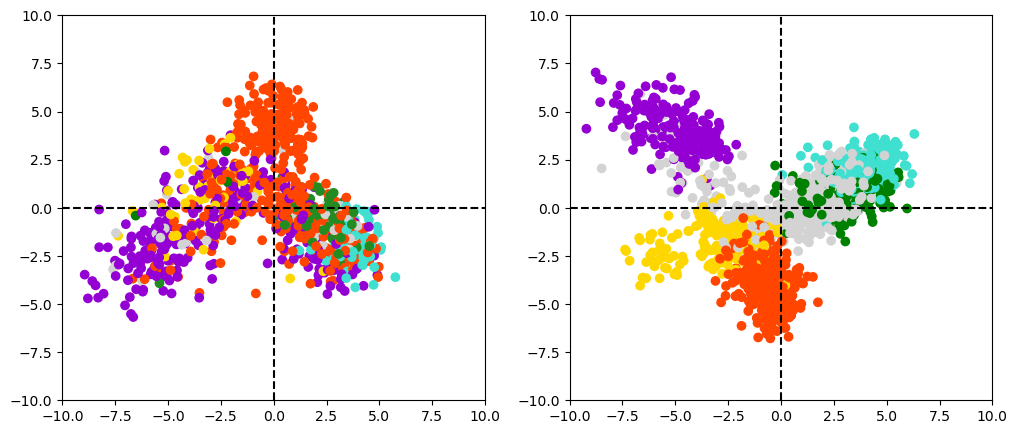

PyObject <matplotlib.lines.Line2D object at 0x23f3406a0>

In [247]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pc1[:,1],pc1[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pc2[:,1],pc2[:,2],c=cols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [248]:
latents = Transpose(get_latent_representation(m,a1.countmatrix))[1:1000,:]

1000×5 Matrix{Float32}:
 -3.75156    3.21607   -0.680137  -4.70096     1.49869
 -2.41068    3.6239    -1.31166   -2.23744    -0.507841
  1.56788   -2.64618   -2.97832    0.280431   -2.58409
 -2.57921    3.62941    0.679594  -4.11071    -0.19913
 -4.3879     0.955593  -0.469294  -2.52807    -0.779227
 -0.723126  -4.52387    1.11534    0.849717   -0.538318
 -1.78344   -2.36122    2.97794    1.36422    -1.43169
  0.659489  -5.8211    -1.05396    0.661385   -3.05213
  1.01553   -2.7433    -1.05552    2.42259    -0.91357
  0.244104  -2.87155    4.47774   -0.0661907  -1.05635
  2.16109    3.60031    0.382993   0.0713565   1.20174
  0.555401  -4.85151    0.953973   0.15489    -1.59152
 -3.49242    1.13864    2.27976   -2.39365     1.22925
  ⋮                                           
 -0.189046  -1.26067   -1.37516    2.63833    -3.05302
  0.830809  -2.78539   -3.61923    1.84822    -1.93098
  0.755344  -1.81515   -2.88152    1.66771    -0.391057
  1.2418    -1.03208    3.01733    2.26157   

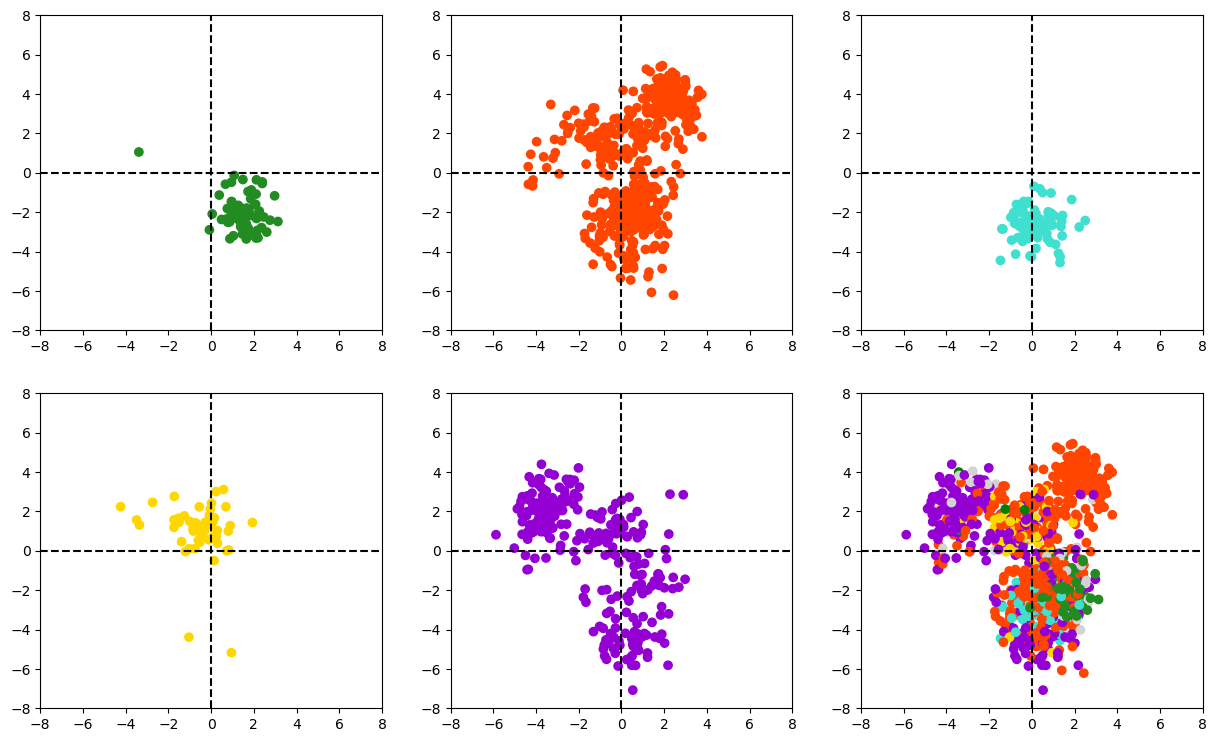

PyObject <matplotlib.lines.Line2D object at 0x23f525fd0>

In [249]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 8
ax[1].scatter(latents[hatcols.=="forestgreen",1],latents[hatcols.=="forestgreen",2],c=hatcols[hatcols.=="forestgreen"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(latents[hatcols.=="gold",1],latents[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(latents[hatcols.=="orangered",1],latents[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(latents[hatcols.=="darkviolet",1],latents[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(latents[hatcols.=="turquoise",1],latents[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(latents[:,1],latents[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")